In [1]:
import numpy as np
import re
import json
import random
import sys
sys.path.append("../../../")
from yelp_multiclass.data.config import getDataFile,getJsonFile,getSentenceDir,getYelpJsonFile
from yelp_multiclass.data.SentencesClasses import getStarRating,getOneHotClass
from collections import OrderedDict
import matplotlib.pyplot as plt


## Setup log configuration

In [2]:
import logging
import sys

root = logging.getLogger()
root.setLevel(logging.DEBUG)

ch = logging.StreamHandler(sys.stdout)
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
root.addHandler(ch)

log = logging.getLogger('Yelp_Review_Processor')
log.setLevel(logging.DEBUG)


## Load Reviews from Yelp JSON


In [3]:
json_path=getYelpJsonFile()

log.info("Processing "+json_path)

reviews={"1":[],"2":[],"3":[],"4":[],"5":[]}

with open(json_path,"r", encoding="utf-8") as f:
    for line in f:
        j=json.loads(line)
        review_list=reviews[str(j["stars"])]
        review_list.append(j["text"])

2018-07-12 21:53:05,763 - Yelp_Review_Processor - INFO - Processing F:\nlp\yelp\dataset\source\review_round11.json


In [4]:
log.info("Parsed "+json_path)

2018-07-12 21:53:48,390 - Yelp_Review_Processor - INFO - Parsed F:\nlp\yelp\dataset\source\review_round11.json


## Plot distribution of reviews

<BarContainer object of 5 artists>

2018-07-12 21:53:48,622 - matplotlib.font_manager - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Python\\Python36\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


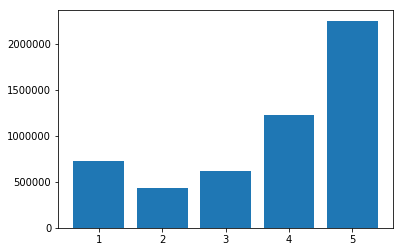

In [5]:
plt.bar([1,2,3,4,5],[len(reviews["1"]),len(reviews["2"]),len(reviews["3"]),len(reviews["4"]),len(reviews["5"])])

# # Concat reviews, 1 & 2 star reviews are negative. 4 & 5 star reviews are positive

In [6]:
negative_reviews= reviews["1"]+reviews["2"]
positive_reviews= reviews["4"]+reviews["5"]

min_reviews=min(len(negative_reviews),len(positive_reviews))



In [7]:
log.info("Count of samples = "+str(min_reviews*2))

random.shuffle(negative_reviews)
random.shuffle(positive_reviews)

log.info("samples shuffled")

train_count=0.6*min_reviews
test_count=val_count=0.2*min_reviews

2018-07-12 21:53:48,920 - Yelp_Review_Processor - INFO - Count of samples = 2339048
2018-07-12 21:53:53,019 - Yelp_Review_Processor - INFO - samples shuffled


## Split into train, test, val 

In [8]:
x_negative_train = negative_reviews[:int(train_count)]
x_negative_test = negative_reviews[len(x_negative_train):len(x_negative_train)+int(test_count)]
x_negative_val = negative_reviews[len(x_negative_train)  +  len(x_negative_test):len(x_negative_train)  +  len(x_negative_test)+int(val_count)]


x_positive_train = positive_reviews[:int(train_count)]
x_positive_test = positive_reviews[len(x_positive_train):len(x_positive_train)+int(test_count)]
x_positive_val = positive_reviews[len(x_positive_train)  +  len(x_positive_test):len(x_positive_train)  +  len(x_positive_test) + int(val_count)]

In [9]:
len(x_negative_train),len(x_negative_test),len(x_negative_val)

(701714, 233904, 233904)

In [10]:
len(x_positive_train),len(x_positive_test),len(x_positive_val)

(701714, 233904, 233904)

In [11]:
y_negative_train=np.repeat(0,len(x_negative_train))
y_negative_test=np.repeat(0,len(x_negative_test))
y_negative_val=np.repeat(0,len(x_negative_val))

y_positive_train=np.repeat(0,len(x_positive_train))
y_positive_test=np.repeat(0,len(x_positive_test))
y_positive_val=np.repeat(0,len(x_positive_val))

#x_train= np.concatenate((x_negative_train, x_positive_train) )
#x_test=  np.concatenate((x_negative_test, x_positive_test) )
#x_val=   np.concatenate((x_negative_val, x_positive_val) )

x_train_sents = x_negative_train + x_positive_train
x_test_sents =  x_negative_test + x_positive_test
x_val_sents =  x_negative_val + x_positive_val

In [12]:
y_train=np.concatenate((y_negative_train,y_positive_train))
y_test=np.concatenate((y_negative_test,y_positive_test))
y_val=np.concatenate((y_negative_val,y_positive_val))


In [13]:
dataset_file="F:\\nlp\\yelp\\dataset\\yelp_review_binary.npz"
#np.savez(dataset_file,x_train=x_train , x_test=x_test, x_val=x_val,y_train=y_train, y_test=y_test, y_val=y_val)

## Prepare vocab

In [14]:
log.info("Preparing vocab")
all_sents=x_train_sents+x_test_sents+x_val_sents
log.info("Number of sentences " + str(len(all_sents)))


2018-07-12 21:53:53,293 - Yelp_Review_Processor - INFO - Preparing vocab
2018-07-12 21:53:53,505 - Yelp_Review_Processor - INFO - Number of sentences 2339044


In [15]:
word_counts={}

for s in all_sents:
    tokens=re.split("[\\s\\.!\\?]+",s);
    for t in tokens:
        ts=t.lower();
        if(ts in word_counts.keys()):
            count=word_counts[ts];
            count += 1;
            word_counts[ts]=count;
        else:
            word_counts[ts] = 1;
log.info("Total words = "+str(len(word_counts.keys())))

2018-07-12 21:57:28,956 - Yelp_Review_Processor - INFO - Total words = 1328644


In [16]:
sorted_touples=sorted(word_counts.items(),  key=lambda x: x[1],reverse=True);

sorted_word_count =  OrderedDict(sorted_touples);

word_idx=OrderedDict();
index=0;
for word in sorted_word_count.keys():
    word_idx[word]=index;
    index+=1;

log.info("Total words in sorted = "+str(len(sorted_word_count.keys())))

2018-07-12 21:57:31,658 - Yelp_Review_Processor - INFO - Total words in sorted = 1328644


In [17]:
def replace_words_with_indices(sent_list):
    ret=[]
    for s in sent_list:
        tokens = re.split("[\\s\\.!\\?]+", s);
        vals = []
        for t in tokens:
            ts = t.lower();
            idx = word_idx[ts]
            vals.append(idx)
        ret.append(vals)
    return ret;

In [18]:
log.info("Replacing words with indices")
x_train=replace_words_with_indices(x_train_sents)
x_test=replace_words_with_indices(x_test_sents)
log.info("Done")


2018-07-12 21:57:31,678 - Yelp_Review_Processor - INFO - Replacing words with indices
2018-07-12 21:59:55,305 - Yelp_Review_Processor - INFO - Done


In [19]:
log.info("Saving data")
npz_dict={'x_train':x_train,'x_test':x_test,'y_train':y_train,'y_test':y_test}
np.savez(dataset_file,**npz_dict)
log.info("Done")

2018-07-12 21:59:55,311 - Yelp_Review_Processor - INFO - Saving data
2018-07-12 21:59:55,312 - Yelp_Review_Processor - INFO - Done


In [21]:
log.info("Saving Vocab in JSON")
json_file=getJsonFile()
with open(json_file, 'w', encoding="utf-8") as fp:
    json.dump(word_idx,fp, indent=4)
log.info("Done")    